In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
import math
from delta_frequency import *

t_pre = 0.5#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [2]:
session = 'MUROLS_20230220/MUROLS_20230220_SESSION_00'
path = '/Volumes/data2/eTheremin/MUROLS/'+ session + '/'

In [3]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True) 
#gc = np.arange(32)
bandwidth = np.load(path+'heatmap_bandwidth.npy', allow_pickle=True)

In [4]:
len(bandwidth)

27

In [5]:
len(gc)

27

In [6]:
#get_delta_f_in_bd(data, features, bandwidth, t_pre, t_post, bin_width, gc)

In [7]:
nt_tracking = [
    sum(1 for feature in features if feature['Frequency_changes'] > 0 and feature['Condition'] == 0 and feature['Block'] == block)
    for block in range(7)
]

nt_mock = [
    sum(1 for feature in features if feature['Mock_change'] > 0 and feature['Condition'] == 1 and feature['Block'] == block)
    for block in range(7)
]

nt_playback = [
    sum(1 for feature in features if feature['Frequency_changes'] > 0 and feature['Condition'] == 1 and feature['Block'] == block)
    for block in range(7)
]


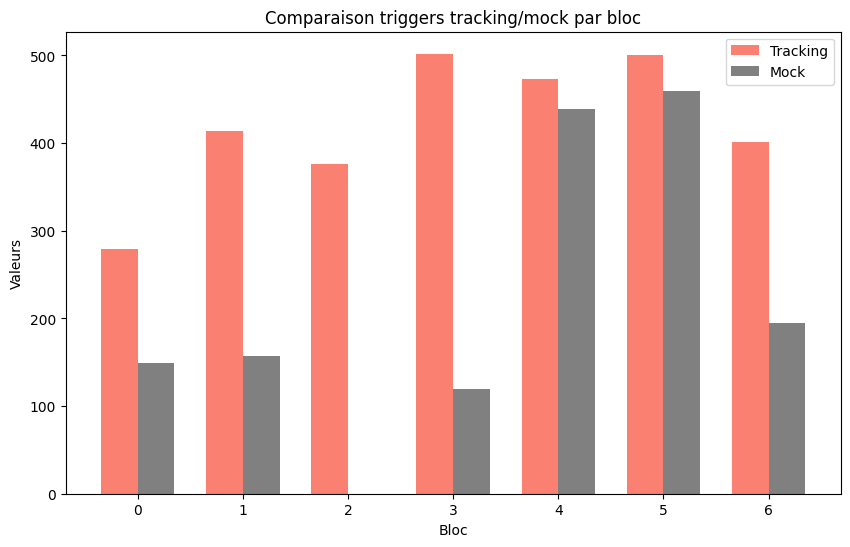

In [8]:
blocks = np.arange(len(nt_tracking))   # Numéro des blocs (0, 1, 2, ...)
width = 0.35                            # Largeur des barres pour chaque condition

# Création des barres
plt.figure(figsize=(10, 6))
plt.bar(blocks - width/2, nt_tracking, width, label='Tracking', color='salmon')
plt.bar(blocks + width/2, nt_mock, width, label='Mock', color='grey')

# Ajout des labels et de la légende
plt.xlabel("Bloc")
plt.ylabel("Valeurs")
plt.title("Comparaison triggers tracking/mock par bloc")
plt.xticks(blocks)  # Position des blocs sur l'axe x
plt.legend()

plt.show()

In [9]:
t_pre = 0.3
t_post = 0.5
mock_psth = get_mock_psth(data, features, t_pre, t_post, bin_width, gc)

In [10]:
bandwidth[11]

array([1111., 2000.])

In [11]:
#psth, delta_f = get_delta_f(data, features, t_pre, t_post, bin_width, gc)
psth, delta_f, f = get_delta_f_in_bd(data, features, bandwidth, t_pre, t_post, bin_width, gc)

/Users/felicie/analysebingobike/delta_frequency.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  diff = math.log2(features[bin]['Played_frequency']/features[bin]['Mock_frequency'])


In [12]:
len(f)

2360

In [13]:
print(len(delta_f), len(psth[0]))

2360 2462


In [14]:
for i, val in enumerate(delta_f):
    if math.isinf(val):  # Si val est 'inf', on le remplace par 0
        delta_f[i] = 0

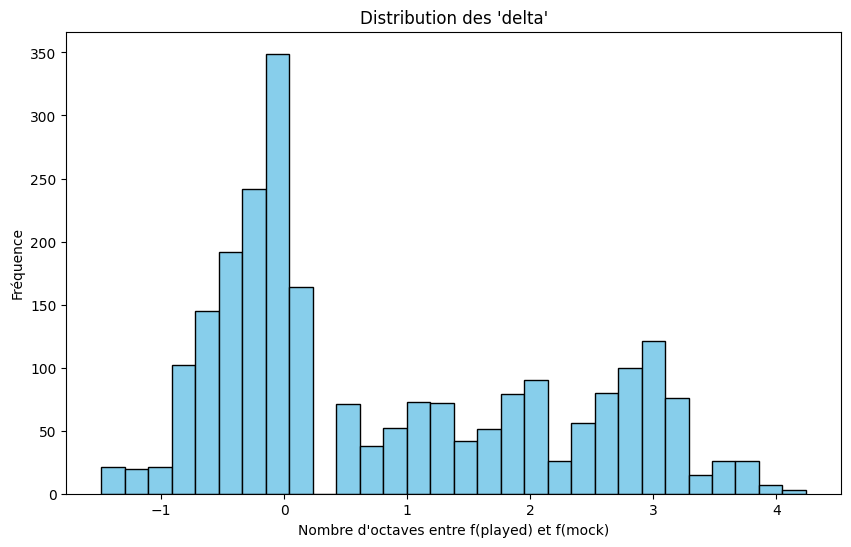

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(delta_f, bins=30, color='skyblue', edgecolor='black')  # Ajustez bins selon la précision souhaitée
plt.title("Distribution des 'delta'")
plt.xlabel("Nombre d'octaves entre f(played) et f(mock)")
plt.ylabel("Fréquence")
plt.show()

In [16]:
delta = histogram_delta(features)

/Users/felicie/analysebingobike/delta_frequency.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  val = math.log2(abs(features[idx]['Played_frequency'] / features[idx]['Mock_frequency']))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2462 but corresponding boolean dimension is 2360

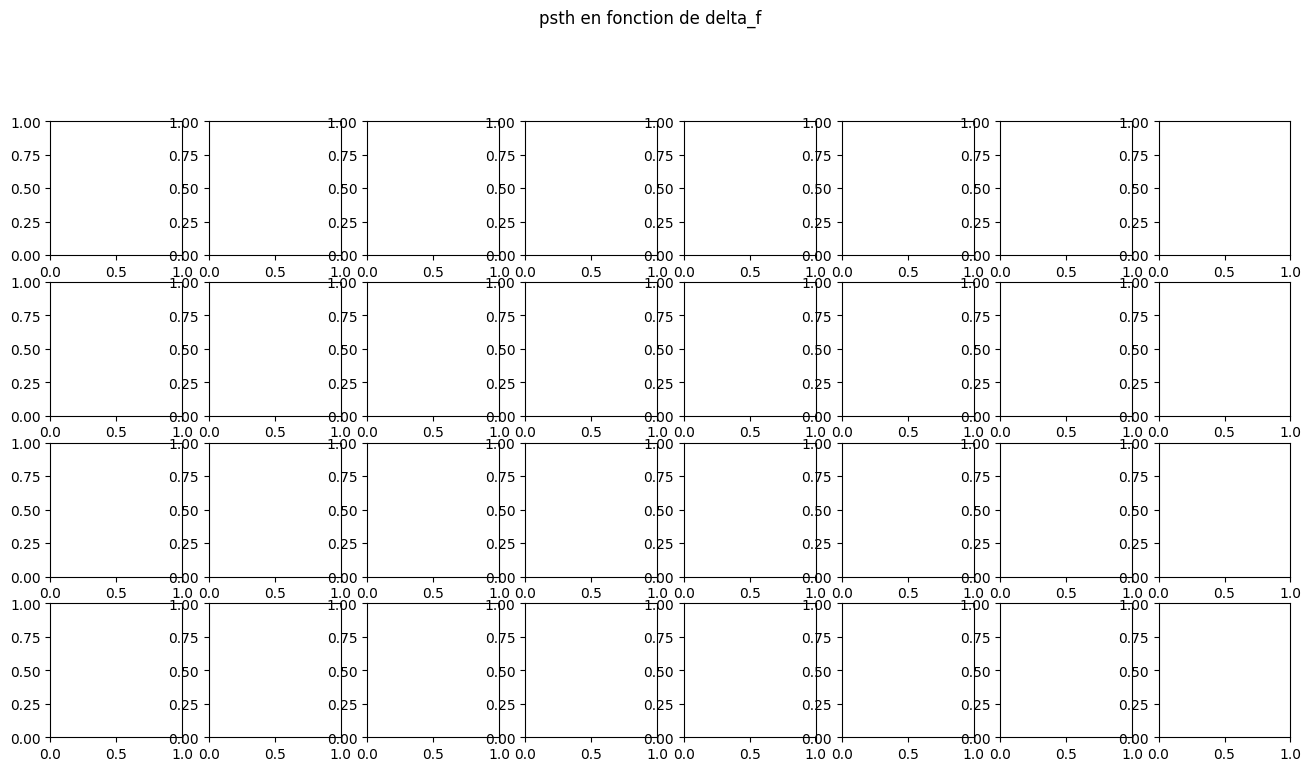

In [17]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('psth en fonction de delta_f', y=1.02)
plt.subplots_adjust() 
delta_f = np.array(delta_f)
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)

for n, cluster in enumerate(gc):
    if n < num_plots:
        clus = np.array(psth[n])
        psth_1_1 = clus[(delta_f >= -1) & (delta_f <= 1)]
        psth_2_2 = clus[(delta_f <-1) | (delta_f >1)]
        #psth_2_plus = clus[delta_f >= 1]
        row, col = get_plot_coords(cluster)
        #axes[row, col].plot(psth_bins, np.nanmean(psth_0_1, axis=0), c = 'red')
        #axes[row, col].plot(psth_bins, np.nanmean(psth_1_3, axis=0), c = 'purple')
        axes[row, col].plot(psth_bins, np.nanmean(psth_2_2, axis=0), c = 'orange')
        axes[row, col].plot(psth_bins, np.nanmean(psth_1_1, axis=0), c = 'red')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

In [ ]:
psth_1, psth_2 = [], []
for n, cluster in enumerate(gc):
    clus = np.array(psth[n])
    psth_1_1 = clus[(delta_f >= -1) & (delta_f <= 1)]
    psth_2_2 = clus[(delta_f <-1) | (delta_f >1)]
    psth_1.append(np.nanmean(psth_1_1, axis=0))
    psth_2.append(np.nanmean(psth_2_2, axis=0))

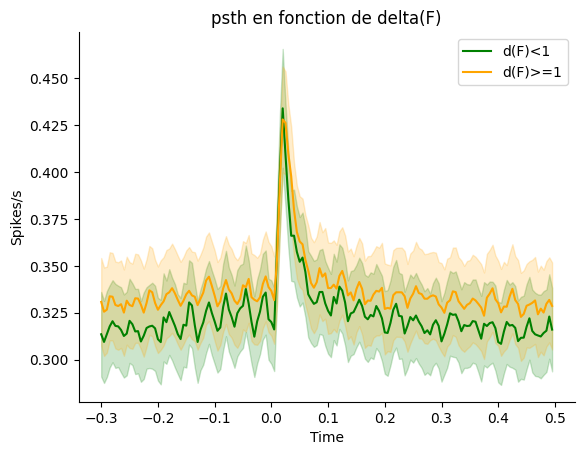

In [ ]:
sem_1 = get_sem(psth_1)
sem_2 = get_sem(psth_2)
plt.plot(psth_bins, np.nanmean(psth_1, axis=0), c = 'green', label='d(F)<1')
plt.plot(psth_bins, np.nanmean(psth_2, axis=0), c = 'orange', label='d(F)>=1')
plt.fill_between(psth_bins, np.nanmean(psth_1, axis=0) - sem_1, np.nanmean(psth_1, axis=0) + sem_1, color='green', alpha=0.2)
plt.fill_between(psth_bins, np.nanmean(psth_2, axis=0) - sem_2, np.nanmean(psth_2, axis=0) + sem_2, color='orange', alpha=0.2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.title('psth en fonction de delta(F)')
plt.xlabel('Time')
plt.ylabel('Spikes/s')
plt.show()

In [ ]:
changes_condition, changes_block = [], []
for i, elt in enumerate(features):
    if np.abs(int(elt['Block'])-int(features[i-1]['Block']))>0.5:
        changes_block.append(i)

    if np.abs(int(elt['Condition'])-int(features[i-1]['Condition']))>0.5:
        changes_condition.append(i)

In [ ]:
print(features[changes_block[1]]['Block'])
print(features[changes_block[1]+50]['Block'])

1.0
1.0


In [ ]:
block = [bin['Block'] for bin in features]
condition = [bin['Condition'] for bin in features]

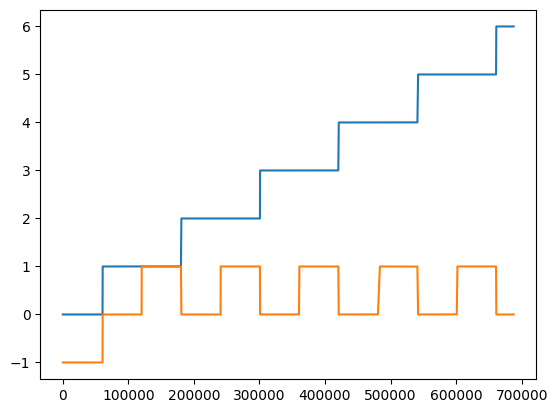

In [ ]:
plt.plot(block)
plt.plot(condition)

In [ ]:
features

array([{'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       ...,
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False, 'Mock_frequency': 1490.0, 'Mock_change': False},
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False, 'Mock_frequency': 1490.0, 'Mock_change': False},
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False, 'Mock_frequency': 1490.0, 'Mock_change': False}],
      dtype=object)

In [ ]:
tracking = [elt for elt in features if elt['Condition'] == 0.0]
playback = [elt for elt in features if elt['Condition'] == 1.0]
tail = [elt for elt in features if elt['Condition'] == -1.0]

In [ ]:
print(len(tracking), len(playback), len(tracking)+len(playback)+len(tail))
print(len(features))

324650 295784 681068
687642


In [ ]:
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
m_tracking = np.nanmean(tracking, axis=1)

In [ ]:
tracking = get_psth()

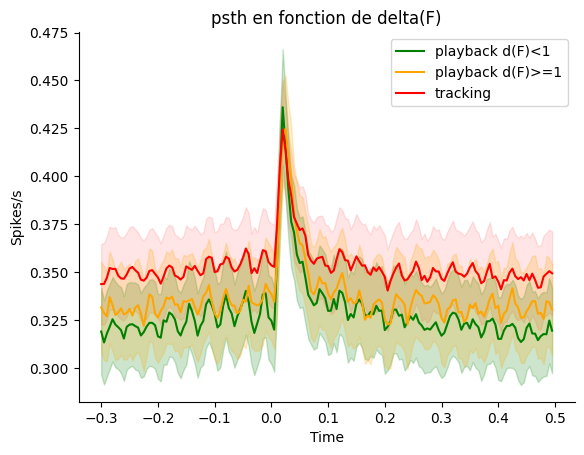

In [ ]:
sem_1 = get_sem(psth_1)
sem_2 = get_sem(psth_2)
sem_tr = get_sem(m_tracking)
plt.plot(psth_bins, np.nanmean(psth_1, axis=0), c = 'green', label='playback d(F)<1')
plt.plot(psth_bins, np.nanmean(psth_2, axis=0), c = 'orange', label='playback d(F)>=1')
plt.plot(psth_bins, np.nanmean(m_tracking, axis=0), c = 'red', label = 'tracking')
plt.fill_between(psth_bins, np.nanmean(m_tracking, axis=0) - sem_tr, np.nanmean(m_tracking, axis=0) + sem_tr, color='red', alpha=0.1)
plt.fill_between(psth_bins, np.nanmean(psth_1, axis=0) - sem_1, np.nanmean(psth_1, axis=0) + sem_1, color='green', alpha=0.2)
plt.fill_between(psth_bins, np.nanmean(psth_2, axis=0) - sem_2, np.nanmean(psth_2, axis=0) + sem_2, color='orange', alpha=0.2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.title('psth en fonction de delta(F)')
plt.xlabel('Time')
plt.ylabel('Spikes/s')
plt.show()